In [1]:
% load_ext autoreload
% autoreload 2

import numpy as np
import time
import datetime
import os 
import matplotlib.pyplot as plt
import matplotlib.style as stl
import matplotlib.gridspec as gridspec
import pickle
import pandas as pd
import seaborn as sns
from scipy import stats
import behav_annotation
from behav_annotation import Behav
from BehavPreprocess_j import BehavPreprocess
from DimReduction import DimReduction
from Segmentation import Segmentation
from GetResults import GetResults
from plot_results_util import *

def fix_layout(width:int=90): 
    from IPython.core.display import display, HTML 
    display(HTML("<style>.container { width:" + str(width) + "% !important; }</style>")) 

fix_layout()
start_time = time.time()

# Reading Data, excluding Rest frames

In [2]:
train_dir = behav_annotation.all_dir #adn_save  #[0:11:3]
fly_tags = behav_annotation.fly_tags #adn_pr_tags #[0:11:3] #IMPORTANT - if >1 pose files in folder, check order below first
val_dir = behav_annotation.train_dir_single #adn_val #val_dir

print("Preprocessing training dataset...")
train_dataset = BehavPreprocess(root_dir=train_dir, min_frequency=3, num_channels=20,
                                wavelet=True, normalize=True, halla_method=True)
print("Preprocessing validation dataset...")
val_dataset = BehavPreprocess(root_dir=val_dir, min_frequency=3, num_channels=20,
                              wavelet=True, normalize=True, halla_method=True)

train_data = train_dataset.data_concat
val_data = val_dataset.data_concat
train_behav = train_dataset.data_behav_concat
val_behav = val_dataset.data_behav_concat

# Low energy frame removal: if mask is turned off, preprocessing will keep all the frames
train_mask = train_behav != Behav.REST.value
val_mask = val_behav != Behav.REST.value
ignore_mask = False
if ignore_mask:
    train_mask = np.logical_not(np.logical_xor(train_mask, train_mask)) #turns mask into all True
    val_mask = np.logical_not(np.logical_xor(val_mask, val_mask))
    
# # Random train mask for sampling [testing]
# train_mask = np.random.choice([0, 1], size=(len(train_data),), p=[1./20, 19./20])==1;

train_data = train_data[train_mask, :]; print(f'train data shape: {np.shape(train_data)}')
val_data = val_data[val_mask, :]; print(f'val data shape: {np.shape(val_data)}')

train_frame_index = train_dataset.frame_idx[train_mask] #array of frames that are not rest frames
train_exp_index = train_dataset.exp_idx[train_mask] #array of experiment labels

train_data[np.logical_or(np.isnan(train_data), np.isinf(train_data))] = 0
val_data[np.logical_or(np.isnan(val_data), np.isinf(val_data))] = 0

train_activity = np.concatenate(train_dataset.frame_activity_list, axis=0)[train_mask]
val_activity = np.concatenate(val_dataset.frame_activity_list, axis=0)[val_mask]

parameters_dict = {}
results_dict = {}
parameters_dict['Preprocess'] = train_dataset.results_dict # TODO (dictionaries aren't prioritary)
results_dict['Preprocess'] = train_dataset.parameters_dict # TODO

Preprocessing training dataset...
Training directories: ['/Volumes/jhc_data/JHC/paper/180920_aDN_PR/Fly2/001_SG1/behData/images/pose_result__data_paper_180920_aDN_PR_Fly2_001_SG1_behData_images.pkl', '/Volumes/jhc_data/JHC/paper/180920_aDN_PR/Fly2/002_SG1/behData/images/pose_result__data_paper_180920_aDN_PR_Fly2_002_SG1_behData_images.pkl', '/Volumes/jhc_data/JHC/paper/180920_aDN_PR/Fly2/003_SG1/behData/images/pose_result__data_paper_180920_aDN_PR_Fly2_003_SG1_behData_images.pkl', '/Volumes/jhc_data/JHC/paper/180920_aDN_PR/Fly2/004_SG1/behData/images/pose_result__data_paper_180920_aDN_PR_Fly2_004_SG1_behData_images.pkl', '/Volumes/jhc_data/JHC/paper/180920_aDN_PR/Fly2/005_SG1/behData/images/pose_result__data_paper_180920_aDN_PR_Fly2_005_SG1_behData_images.pkl', '/Volumes/jhc_data/JHC/paper/180920_MDN_PR/Fly9/001_SG1/behData/images/pose_result__data_paper_180920_MDN_PR_Fly9_001_SG1_behData_images.pkl', '/Volumes/jhc_data/JHC/paper/180920_MDN_PR/Fly9/002_SG1/behData/images/pose_result__d

/Users/joaohenrique/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/joaohenrique/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/joaohenrique/Documents/EPFL/joao_pose/joint_functions.py:826: RuntimeWarning: invalid value encountered in greater
  too_far_away = abs(datamat_j[:, joint] - mean_before_first) > ld_correction*2 # Find the points that are too far away from that point


Number of nan or inf after angles: 0
COXA ANGLE DIFFERENCE 0.06617656260850602
Calculating joint angles...
Number of nan or inf after angles: 0
COXA ANGLE DIFFERENCE 0.06864975522549477
Calculating joint angles...
Number of nan or inf after angles: 0
COXA ANGLE DIFFERENCE 0.03885735824727776
Calculating joint angles...
Number of nan or inf after angles: 0
COXA ANGLE DIFFERENCE 0.026078452550907905
Calculating joint angles...
Number of nan or inf after angles: 0
COXA ANGLE DIFFERENCE -0.0239036919452702
Calculating joint angles...
Number of nan or inf after angles: 0
COXA ANGLE DIFFERENCE 0.3090018739192417
Calculating joint angles...
Number of nan or inf after angles: 0
COXA ANGLE DIFFERENCE 0.4699502149508139
Calculating joint angles...
Number of nan or inf after angles: 0
COXA ANGLE DIFFERENCE 0.27298254720367376
Calculating joint angles...
Number of nan or inf after angles: 0
COXA ANGLE DIFFERENCE 0.14839855359211418
Calculating joint angles...
Number of nan or inf after angles: 0
C

# Dimensionality Reduction

In [3]:
low_dim = DimReduction(train_data.copy(), val_data.copy(), single=False, use_tsne=True, validation=False,
                       pca_dim=45, tsne_per=np.sqrt(np.shape(train_data)[0])) # if use_tsne=False, uses PCA
low_dim_train = low_dim.low_dim_train
# low_dim_val = low_dim.low_dim_val
parameters_dict['DimReduct'] = low_dim.results_dict
results_dict['DimReduct'] = low_dim.parameters_dict

Total explained variance: [0.19383774 0.28786844 0.35853178 0.42616113 0.46957426 0.50073824
 0.53117087 0.55605332 0.57774002 0.59915962 0.61925855 0.63820515
 0.65464701 0.66995029 0.68335508 0.69552752 0.70603195 0.71636788
 0.72648064 0.7358341  0.74439175 0.75218608 0.75954479 0.7666752
 0.77365436 0.78044499 0.78654272 0.79234462 0.79809243 0.80360392
 0.80872333 0.81366397 0.81845803 0.82317044 0.8274496  0.83168062
 0.83583371 0.83982273 0.84356065 0.84719498 0.85071453 0.8540851
 0.85740109 0.86058355 0.8636275 ]
Applying t-SNE with parameters {'perplexity': 126.90941651429968, 'early_exaggeration': 20.0, 'learning_rate': 100, 'n_iter': 2500, 'n_iter_without_progress': 300, 'min_grad_norm': 1e-07, 'metric': 'euclidean', 'init': 'random', 'verbose': 2, 'random_state': None, 'method': 'barnes_hut', 'angle': 0.3}
[t-SNE] Computing 381 nearest neighbors...
[t-SNE] Indexed 16106 samples in 0.100s...
[t-SNE] Computed neighbors for 16106 samples in 28.741s...
[t-SNE] Computed conditi

# Segmentation of low dimensional space

In [4]:
segmentation = Segmentation(low_dim_train.copy(), train_data.copy(),
                            mode=2, mesh_mag=1, xmax=500, ymax=500, wat_ksize=4, gmm_comps=85,
                            hdbscan_cut=0.019, hdbscan_min=5, hdbscan_hdim=False)
                            #TIPS - For PCA, mesh_mag =3-5k | if t-SNE =1 || HDBSCAN h_dim cut: 0.018; low_dim: 3.5
cluster_labels = segmentation.labels
mesh_bool = segmentation.is_mesh_labels #if labels come from a mesh space (used for Gaussian convolution - mode=0)

Performing GMM on the 2D embedded posture-dynamics space
Number of clusters: 85
Segmentation completed. Time elapsed: 4.279146909713745 seconds


# Create and store: results dictionary + cluster videos

In [5]:
# Create save directories:
time = datetime.datetime.fromtimestamp(start_time).strftime('%Hh%Mm_%d_%m_%Y')
results_dir = f'/Users/joaohenrique/Documents/EPFL/joao_pose/results/{time}'
fly_vid_dir = results_dir + '/fly_vid'
cluster_vid_dir = results_dir + '/cluster_vid'
try:
    os.makedirs(results_dir)
    os.makedirs(fly_vid_dir)
    os.makedirs(cluster_vid_dir)
except FileExistsError:
    pass

# Generate trial results dictionary:
results = GetResults(cluster_labels, low_dim_train.copy(), mesh_bool, segmentation.pix_to_point_idx, 
                     segmentation.point_idx_to_pix, train_exp_index, train_frame_index, segmentation.xmax, segmentation.ymax, 
                     train_dataset.exp_path_list, fly_vid_dir, cluster_vid_dir, min_cluster_size=10, get_videos=False)

# save the dict
with open(results_dir + '/train_results.pickle', 'wb') as handle:
    pickle.dump(results.cluster_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

Results created and stored. Time elapsed: 0.09095287322998047 seconds


In [6]:
results.cluster_dict

{'cluster0': {'/Volumes/jhc_data/JHC/paper/180921_aDN_CsCh/Fly5/002_SG1/behData/images/pose_result__data_paper_180921_aDN_CsCh_Fly5_002_SG1_behData_images.pkl': {'sequence_1': {'frames': array([624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636,
           637, 638, 639, 640, 641, 642, 643]),
    'x': array([39.802452, 39.744434, 39.678375, 39.599728, 39.51012 , 39.401527,
           39.29626 , 39.20679 , 39.091618, 38.972336, 38.85148 , 38.72441 ,
           38.586308, 38.442696, 38.29551 , 38.133263, 37.972538, 37.7884  ,
           37.603424, 37.409252], dtype=float32),
    'y': array([40.9265  , 40.91441 , 40.94789 , 40.98181 , 40.740765, 41.108654,
           41.131027, 40.66673 , 40.650475, 40.667553, 41.105156, 41.087864,
           40.703053, 40.766273, 41.03726 , 40.68717 , 40.990177, 40.92144 ,
           40.836376, 40.899254], dtype=float32)}},
  '/Volumes/jhc_data/JHC/paper/180921_aDN_CsCh/Fly5/003_SG1/behData/images/pose_result__data_paper_180921_aDN_CsCh_Fly5

# Plots

## Preprocessing

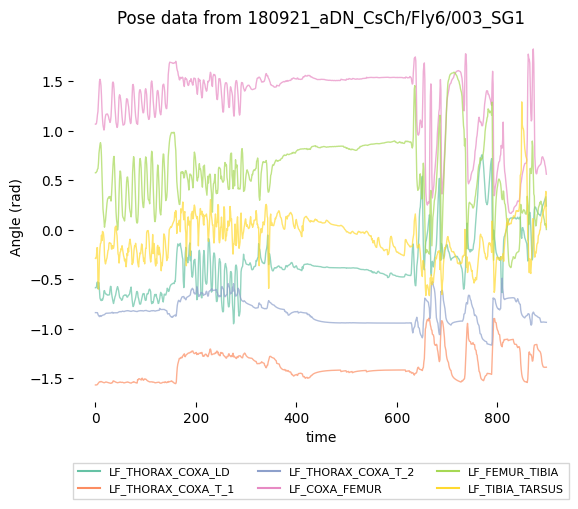

In [43]:
# See POSTURAL TIME SERIES:
stl.use('default')
see_postural_series(train_dataset.angl_exp_list.copy(), fly_tags, exp=21, joint=0, limb=0, H_angle=True)

In [ ]:
# See all joint angles with statistical error data
see_post_series_stat(train_dataset.angl_exp_list.copy()) # best to keep rest frames so that discontinuities aren't considered

shapes: (120, 899) (899,)


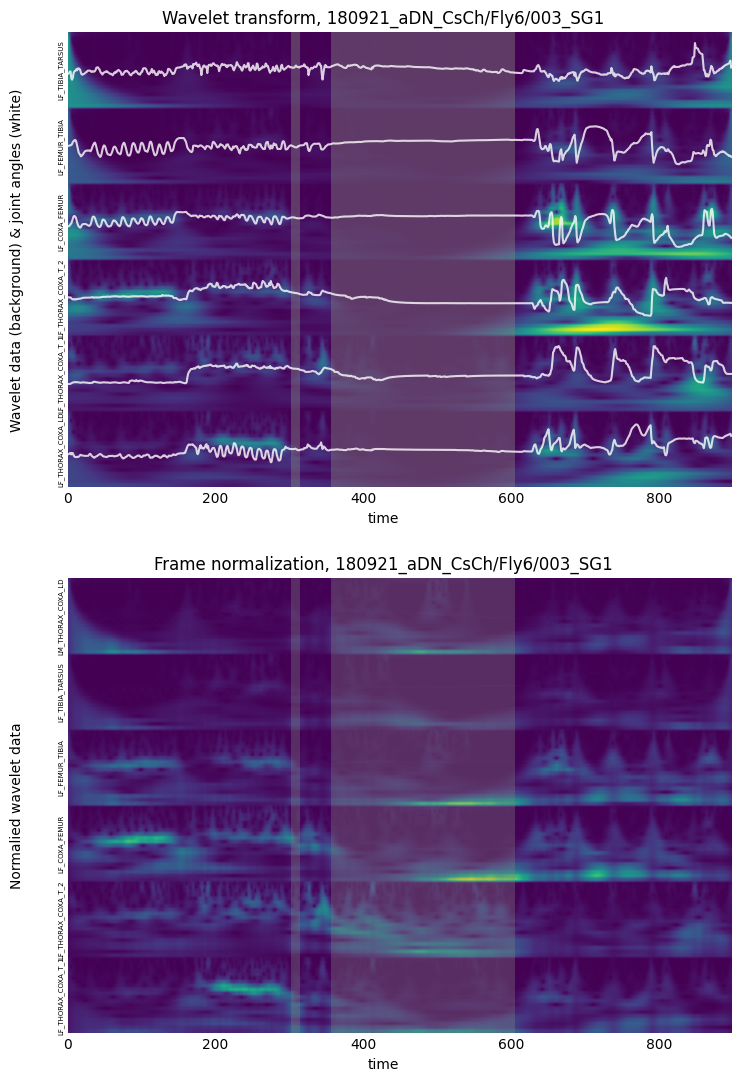

In [46]:
# TIME-FREQUENCY ANALYSIS: single plot from 1 joint and subject + all plots (pre and post NORMALIZATION step)
# WARNING: plot is different when called the 2nd time for the same joint angles (don't know why yet)
plt_wav(train_dataset.angl_exp_list.copy(), train_dataset.test_rest_mask, fly_tags, exp=21, j_ang=0, num_ang=6, 
        fps=100, chan=20, fmin=1, fmax=50, y_size=13, show_rest=True, show_pose=True, H_angles=True)

log10(variance threshold): -4.290214042818132
variance threshold: 5.1260868161146515e-05


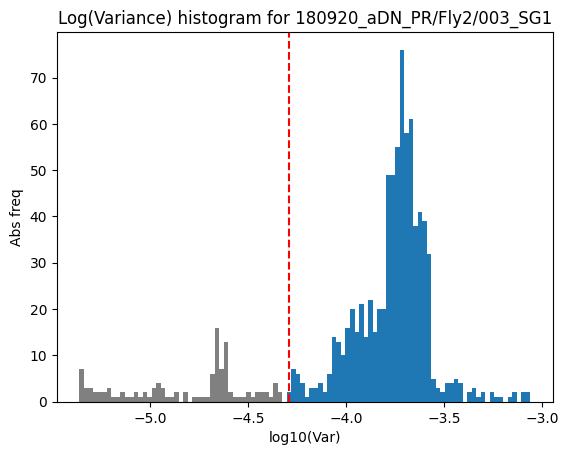

In [9]:
# Activity distribution and OTSU'S METHOD for clustering REST FRAMES:
is_bimodal(train_dataset.frame_var_list, fly_tags, exp=2, nbins=100) #correct map limits

## Dimensionality Reduction

$Z_1$       $Z_2$  Frame activity            Subject  Genotype  \
0      26.604958   82.904327        1.448508    aDN_PR/Fly2/001    aDN_PR   
1      26.178970   82.935699        1.422687    aDN_PR/Fly2/001    aDN_PR   
2      25.112505   83.100266        1.377011    aDN_PR/Fly2/001    aDN_PR   
3      23.460489   83.127083        1.321168    aDN_PR/Fly2/001    aDN_PR   
4      19.355938   83.758469        1.264713    aDN_PR/Fly2/001    aDN_PR   
5      17.098553   84.550018        1.213413    aDN_PR/Fly2/001    aDN_PR   
6      15.092989   85.608070        1.168831    aDN_PR/Fly2/001    aDN_PR   
7      13.934071   86.415642        1.127449    aDN_PR/Fly2/001    aDN_PR   
8      12.160305   87.643188        1.087856    aDN_PR/Fly2/001    aDN_PR   
9      10.916252   88.717972        1.050022    aDN_PR/Fly2/001    aDN_PR   
10      9.821943   89.964081        1.013641    aDN_PR/Fly2/001    aDN_PR   
11      9.037436   91.179993        0.978501    aDN_PR/Fly2/001    aDN_PR   
12      8.132527   92.566559        0.944430    aDN_PR/Fly2/001    aDN_PR   
13      7.396609   93.944084        0.911251    aDN_PR/Fly2/001    aDN_PR   
14      6.964645   94.843422        0.878681    aDN_PR/Fly2/001    aDN_PR   
15      6.590832   95.648582        0.846685    aDN_PR/Fly2/001    aDN_PR   
16      6.333515   96.387909        0.815238    aDN_PR/Fly2/001    aDN_PR   
17      6.223319   97.009888        0.784099    aDN_PR/Fly2/001    aDN_PR   
18     -0.054018  101.482986        0.753211    aDN_PR/Fly2/001    aDN_PR   
19     -0.152191  101.998886        0.722590    aDN_PR/Fly2/001    aDN_PR   
20     -0.246852  102.449867        0.692523    aDN_PR/Fly2/001    aDN_PR   
21     -0.349495  102.889305        0.663008    aDN_PR/Fly2/001    aDN_PR   
22     -0.483649  103.367828        0.633746    aDN_PR/Fly2/001    aDN_PR   
23     -0.523027  107.041039        0.604271    aDN_PR/Fly2/001    aDN_PR   
24     -0.489464  107.560379        0.574380    aDN_PR/Fly2/001    aDN_PR   
25     -0.482558  108.003105        0.544253    aDN_PR/Fly2/001    aDN_PR   
26     -0.494217  108.410835        0.513886    aDN_PR/Fly2/001    aDN_PR   
27     -0.523358  108.815865        0.482482    aDN_PR/Fly2/001    aDN_PR   
28     -0.576596  109.259827        0.449692    aDN_PR/Fly2/001    aDN_PR   
29     -1.077494  114.747017        0.416355    aDN_PR/Fly2/001    aDN_PR   
...          ...         ...             ...                ...       ...   
16076   4.081181  112.713844        0.423564  aDN_CsCh/Fly7/004  aDN_CsCh   
16077   3.734063  111.523651        0.455521  aDN_CsCh/Fly7/004  aDN_CsCh   
16078   3.507980  110.440491        0.487289  aDN_CsCh/Fly7/004  aDN_CsCh   
16079   3.445384  109.290909        0.518631  aDN_CsCh/Fly7/004  aDN_CsCh   
16080   3.421762  108.186157        0.549525  aDN_CsCh/Fly7/004  aDN_CsCh   
16081   3.413876  107.145599        0.580124  aDN_CsCh/Fly7/004  aDN_CsCh   
16082   3.429436  105.991402        0.610710  aDN_CsCh/Fly7/004  aDN_CsCh   
16083   3.428369  104.793953        0.641511  aDN_CsCh/Fly7/004  aDN_CsCh   
16084   3.479011  103.587196        0.672665  aDN_CsCh/Fly7/004  aDN_CsCh   
16085   3.658036  102.288765        0.704086  aDN_CsCh/Fly7/004  aDN_CsCh   
16086   3.757431  100.843887        0.735653  aDN_CsCh/Fly7/004  aDN_CsCh   
16087   3.833569   99.266739        0.767336  aDN_CsCh/Fly7/004  aDN_CsCh   
16088   3.976275   97.865654        0.799171  aDN_CsCh/Fly7/004  aDN_CsCh   
16089   4.176947   96.346169        0.831245  aDN_CsCh/Fly7/004  aDN_CsCh   
16090   4.398402   94.709496        0.863707  aDN_CsCh/Fly7/004  aDN_CsCh   
16091   4.826473   93.159447        0.896552  aDN_CsCh/Fly7/004  aDN_CsCh   
16092   5.339454   91.787224        0.929809  aDN_CsCh/Fly7/004  aDN_CsCh   
16093   6.163370   90.278671        0.963646  aDN_CsCh/Fly7/004  aDN_CsCh   
16094   7.227921   88.909607        0.998218  aDN_CsCh/Fly7/004  aDN_CsCh   
16095   8.439104   87.606857        1.033587  aDN_CsCh/Fly7/004  aDN_CsCh   
16096  

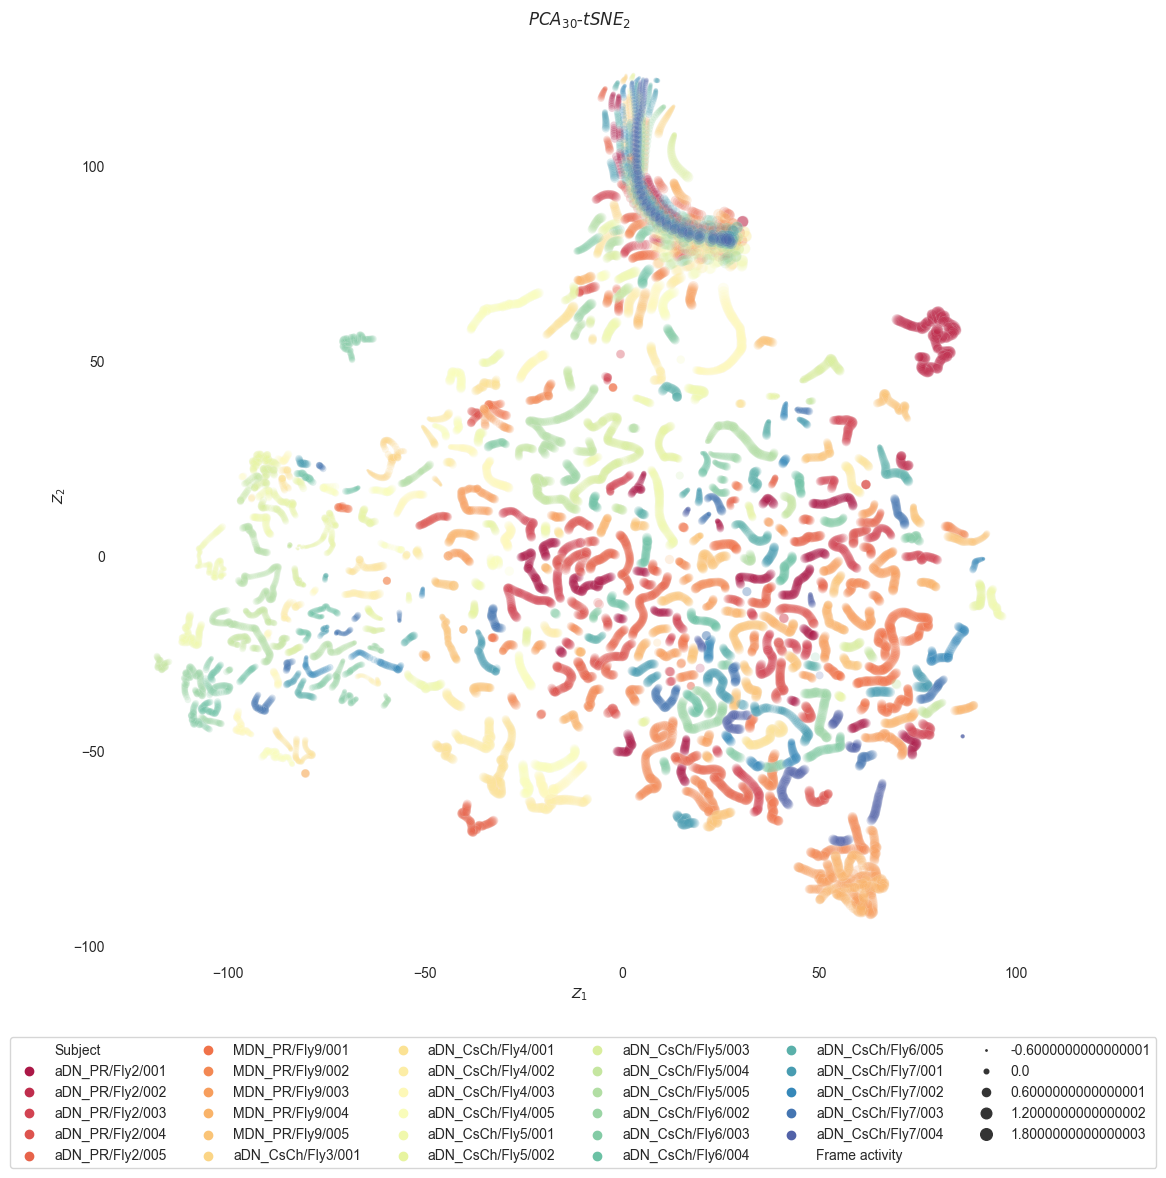

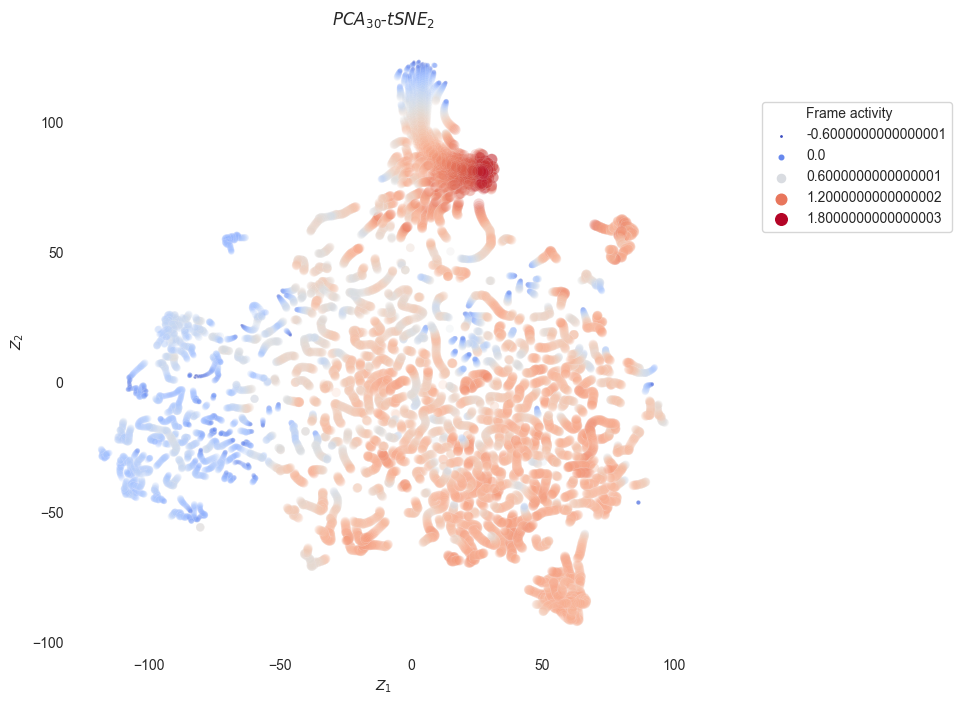

In [10]:
# Multiple scatter plots of the embedded 2D data
## reset parameters
plt.rcParams.update(plt.rcParamsDefault)
sns.set_style("white") # plt.style.use('dark_background')

data_frame_2d = see_2D_data(low_dim_train.copy(), np.log10(train_activity), 
                            fly_tags, train_exp_index, low_dim.reducer_tag, short_tags=True, tag_end=13)
data_frame_2d

## Segmentation

In [11]:
if segmentation.mode==0: #Watershed
    plt.imshow(cluster_labels==50)
elif segmentation.mode==1: #HDBSCAN
    f = plt.figure(figsize=(12,6))
    f.suptitle(pipeline, fontsize=18, y=.9, x=.5) # title eg.'$PCA_3$'+'$_0$'+'-$tSNE_2$'+'-$HDBSCAN$'
    ax1 = plt.subplot(1,1,1)
    sns.distplot(segmentation.hdbscan_scores[np.isfinite(segmentation.hdbscan_scores)], rug=False, ax=ax1)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
#     segmentation.single_linkage_tree.plot(axis=ax1)
#     ax2 = plt.subplot(2,1,2)
#     segmentation.cond_tree.plot(axis=ax2)

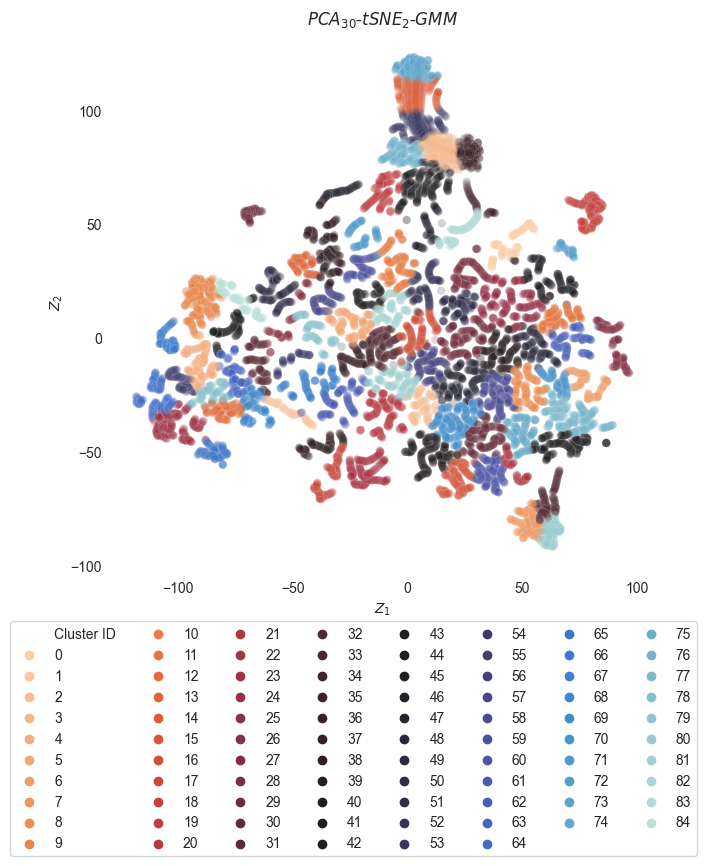

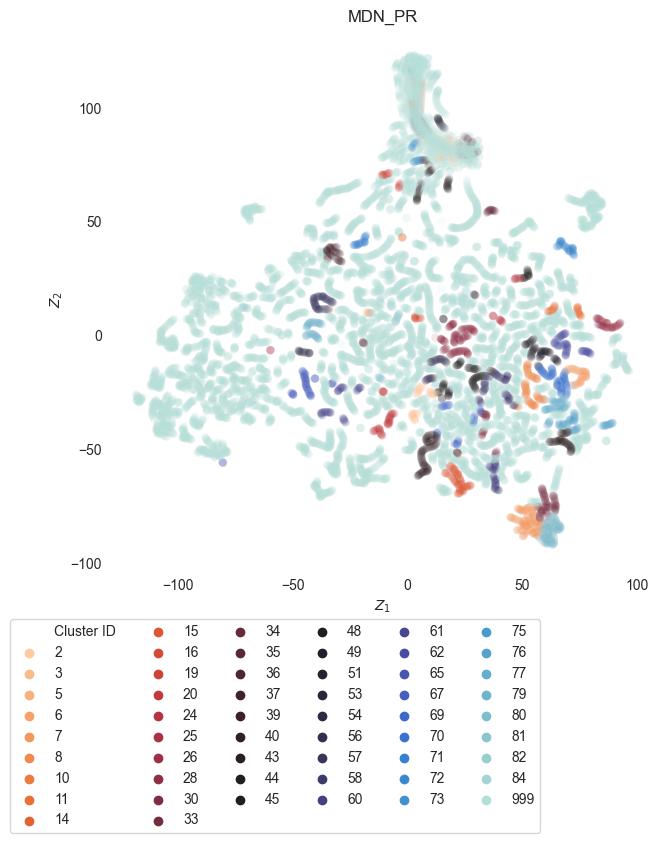

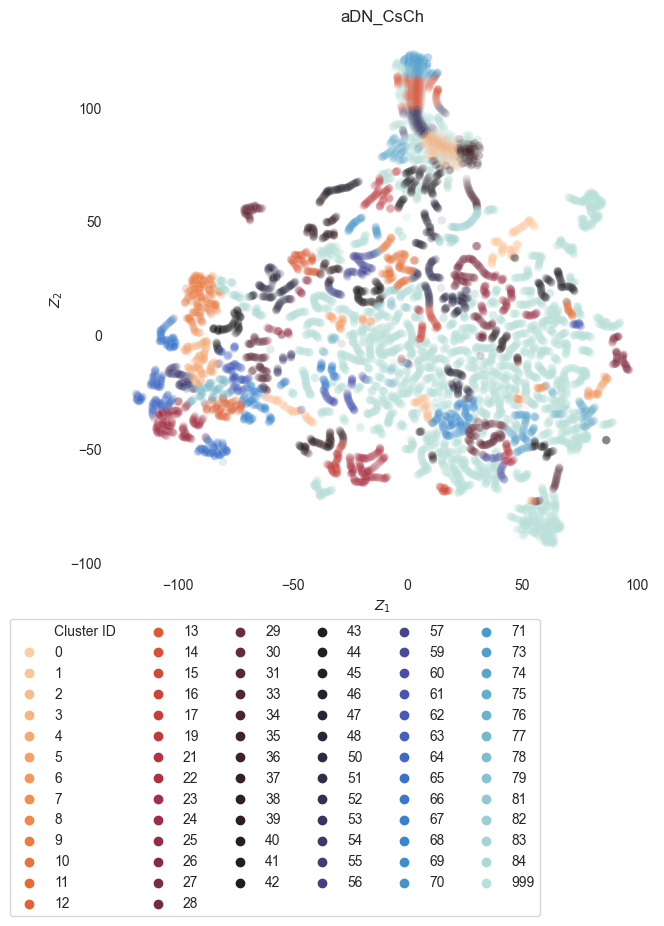

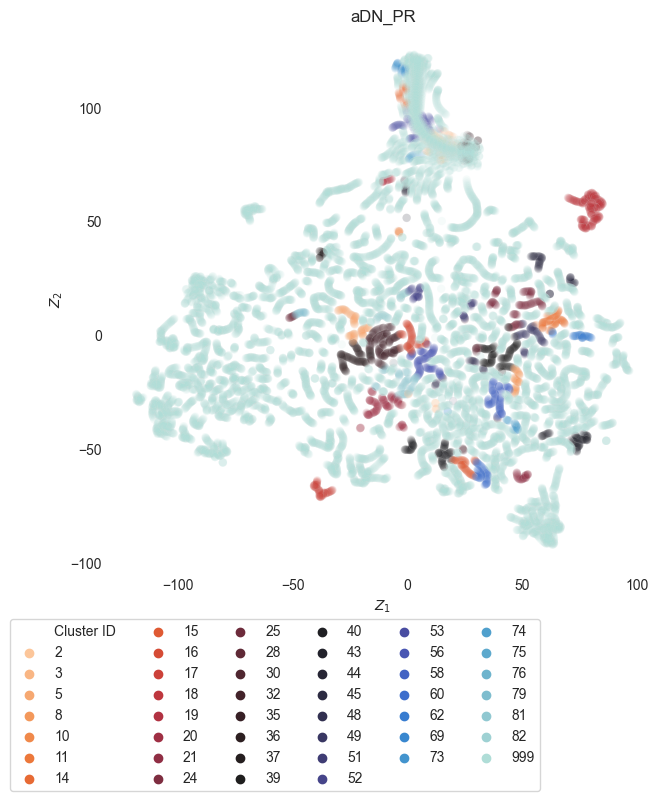

In [11]:
# See if mesh is ok. Pay attention to the MAGNITUDE parameter (Segmentation.py) when using Watershed 
# since t-SNE and PCA call for very different values.
pipeline = low_dim.reducer_tag + segmentation.seg_tag
data_frame_cluster = plt_segmentation(low_dim_train.copy(), cluster_labels, segmentation.prob_dens_f, segmentation.mesh,
                 segmentation.mask, mesh_bool, data_frame_2d, segmentation.mesh_mag,
                 segmentation.post_proba, segmentation.mode, segmentation.xmax, segmentation.ymax, 
                 segmentation.pix_to_point_idx, pipeline)

## Cluster analysis

/Users/joaohenrique/Documents/EPFL/joao_pose/plot_results_util.py:663: RuntimeWarning: divide by zero encountered in log
  np.log(totals), outliers, np.log(outliers)]),


Mean dwell time is 22.24585635359116 frames
Cluster entropy is 4.385685823332776


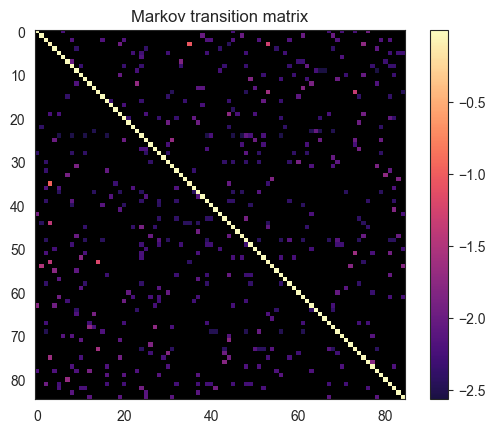

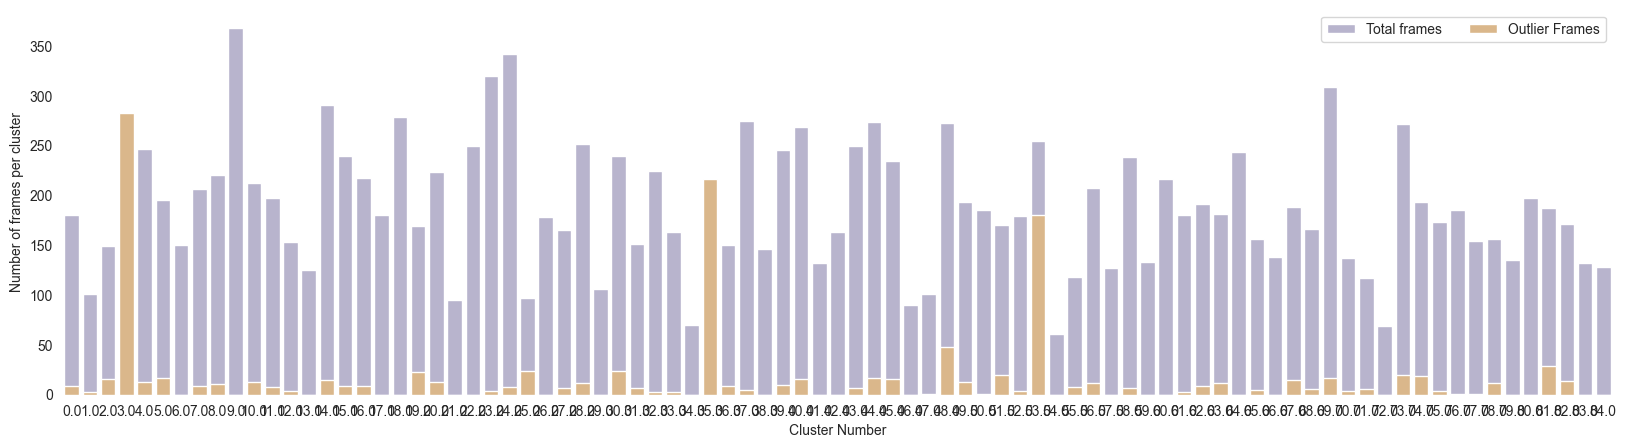

In [12]:
m = plot_Markov_matx(segmentation.mesh, segmentation.labels, segmentation.pix_to_point_idx,
                     segmentation.xmax, segmentation.ymax, mode=segmentation.mode)
frame_numbers, mean_dwell, cluster_entropy = cluster_frame_dist(results.cluster_dict)
plot_cluster_frame_dist(frame_numbers, dims=(20, 5))

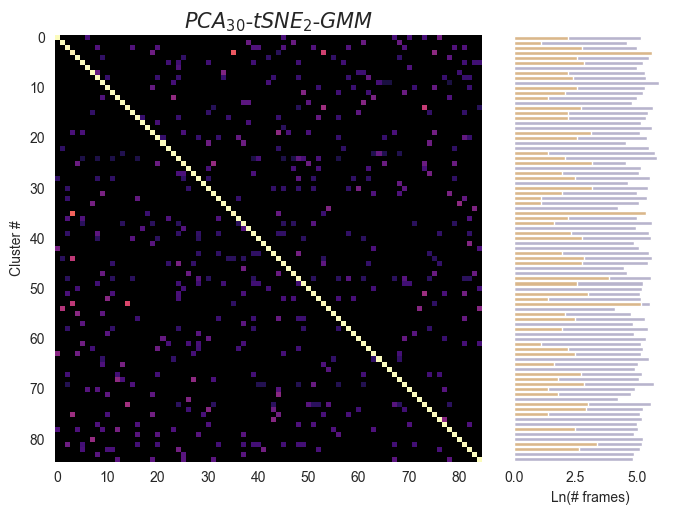

In [13]:
#Merge 2 previous plots
plot_markov_hist(m, frame_numbers, titl=pipeline, dims=(7,5))  #'$PCA_3$'+'$_0$'+'-$tSNE_2$'+'-$HDBSCAN$'

Fly centroid distances std dev: 25858.41214287853


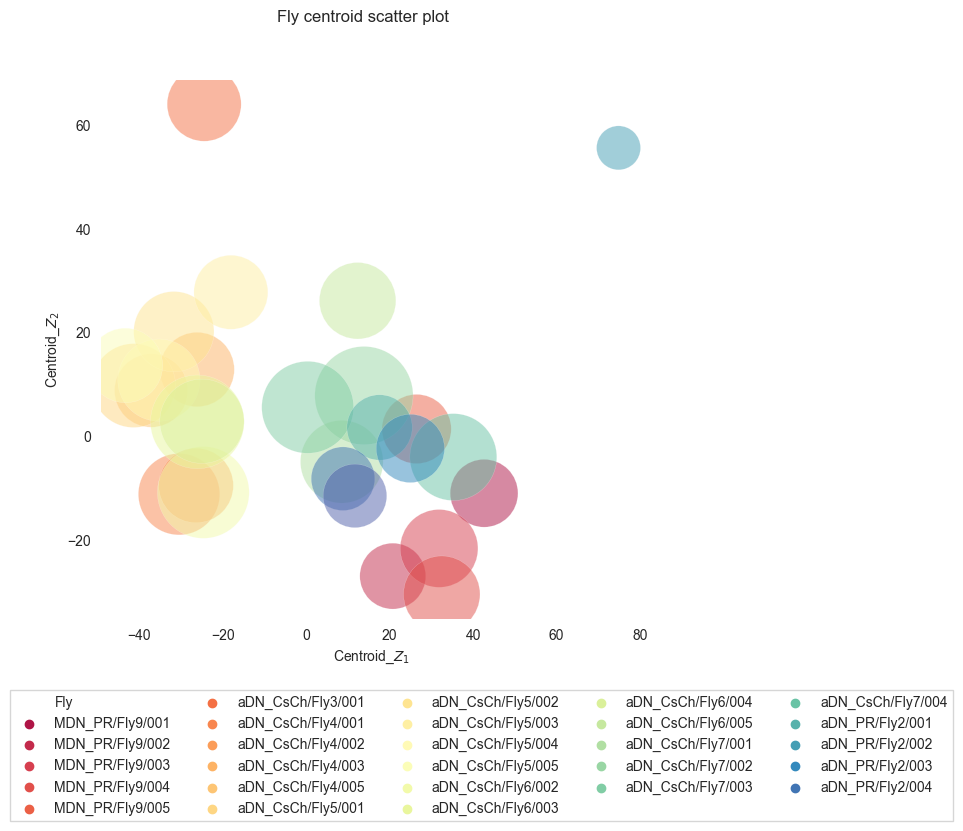

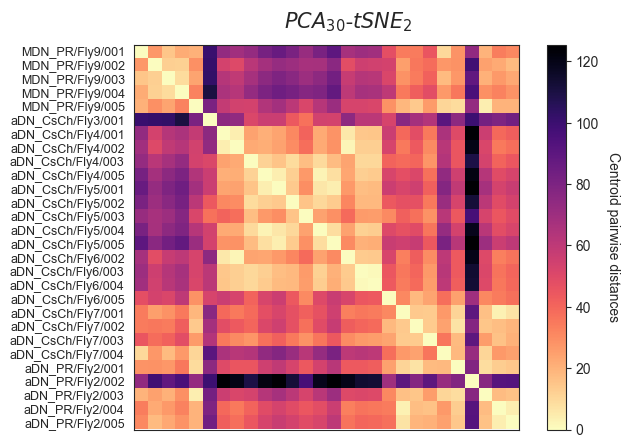

In [14]:
# Cluster Centroids for each fly
fly_centroids, fly_uncomp, centroid_dists, fly_arrays, embed_homog = fly_frame_dist(data_frame_cluster, low_dim.reducer_tag)

## Store relevant metrics 

In [15]:
# Store: Entropy, Mean dwell time, pipeline total run time, prameters used (check modules) ...
run_t = train_dataset.dt+low_dim.dt+segmentation.dt
metrics_df = store_metrics(pipeline+'_$39a$', cluster_entropy, mean_dwell, embed_homog, run_t, new_df=False)
metrics_df

Pipeline   Entropy        Mdt   Homogeneity  \
0  $PCA_3$$_0$-$tSNE_2$-$Random$_$39a$  4.315340   1.012192  21717.617768   
1  $PCA_3$$_0$-$tSNE_2$-$Random$_$39a$  4.315051   1.012510  20765.433405   
2     $PCA_3$$_0$-$tSNE_2$-$GMM$_$39a$  4.392931  29.102890  21626.033229   
3                 $tSNE_2$-$GMM$_$39a$  4.393680  31.906210  23459.030657   
4     $PCA_3$$_0$-$tSNE_2$-$GMM$_$39a$  4.391698  21.647849  23887.472907   
5     $PCA_3$$_0$-$tSNE_2$-$GMM$_$39a$  4.385686  22.245856  25858.412143   

           Time  
0   1374.667881  
1   1374.670403  
2   9211.491167  
3  49774.312396  
4   1258.867973  
5   1242.970653

In [ ]:
# metrics_df = delete_df_line('/Users/joaohenrique/Documents/EPFL/joao_pose/results' + '/metrics_df.pickle', [8,33])
# metrics_df

## Testing

In [25]:
freq_z1 = [3+20*0, 12+20*0, 19+20*0] # compare 2 by 2
freq_z2 = [3+20*20, 32+20*20, 39+20*20]
freqs = train_dataset.parameters_dict['wavelet_frequencies']
modes_z1 = np.hstack([train_data[:2000,i]*10**5 for i in freq_z1])
modes_z2 = np.hstack([train_data[:2000,i]*10**5 for i in freq_z2])
l = np.shape(train_data[:,0])[0]
names = list()
names.extend([f'f={freqs[freq_z1[0]]}Hz' for i in range(2000)])
# names.extend([f'f={freqs[freq_z1[1]]}Hz' for i in range(1000)])
# names.extend([f'f={freqs[freq_z1[2]]}Hz' for i in range(1000)])
mode_df = pd.DataFrame(np.transpose([modes_z1, modes_z2, names]), columns=['$A_i$','$A_j$','Frequency'])
mode_df

$A_i$               $A_j$               Frequency
0      153.7475156087612  110.09153061305891  f=11.373436705660083Hz
1     159.74914948603117  114.37797832307393  f=11.373436705660083Hz
2     170.16057169871567   121.8195845915981  f=11.373436705660083Hz
3     181.71110055328015  130.07323919084862  f=11.373436705660083Hz
4     190.30513561655783  136.20566405793485  f=11.373436705660083Hz
5     192.88787266499844   138.0289951715405  f=11.373436705660083Hz
6     188.53128933488122   134.8776391686092  f=11.373436705660083Hz
7     179.14446841008603  128.11544202009011  f=11.373436705660083Hz
8      166.0218424325211  118.66524405272727  f=11.373436705660083Hz
9      150.0624698365916  107.16663972494787  f=11.373436705660083Hz
10     132.3668068819924    94.4035562392479  f=11.373436705660083Hz
11     113.9760510519494   81.11871857665706  f=11.373436705660083Hz
12     95.81163704600837   67.97142117176195  f=11.373436705660083Hz
13     78.62889864355438  55.505324966410676  f=11.373436705660083Hz
14     62.99644086839052   44.13411935246429  f=11.373436705660083Hz
15     49.23317394057797  34.097158149840176  f=11.373436705660083Hz
16     37.48409039824285  25.512445231590178  f=11.373436705660083Hz
17     27.76304642572191  18.403887466065004  f=11.373436705660083Hz
18    19.956990223129235   12.70071549465251  f=11.373436705660083Hz
19    13.907323060169995   8.288994372760476  f=11.373436705660083Hz
20     9.488716091957064   5.066391381208657  f=11.373436705660083Hz
21     6.716130085081799   3.059601914068831  f=11.373436705660083Hz
22     5.645587766743367  2.4422793147930344  f=11.373436705660083Hz
23     5.867856777248737  2.7853903241996925  f=11.373436705660083Hz
24     6.607493130157773  3.2860841324726486  f=11.373436705660083Hz
25     7.375388634171037  3.6408621505155683  f=11.373436705660083Hz
26      7.99137881962248  3.7999992983118567  f=11.373436705660083Hz
27     8.422941532418122  3.7830977264554106  f=11.373436705660083Hz
28     8.675022677028666   3.621338586544901  f=11.373436705660083Hz
29      8.73459821093684   3.345686159572343  f=11.373436705660083Hz
...                  ...                 ...                     ...
1970  47.644703413429156  50.020824142999246  f=11.373436705660083Hz
1971   47.55458841685665   46.89253894665652  f=11.373436705660083Hz
1972   46.92175896916775   43.65499120265862  f=11.373436705660083Hz
1973  45.860783949189255  40.555876781395895  f=11.373436705660083Hz
1974   44.62589950946257   37.90525407145124  f=11.373436705660083Hz
1975  43.189585146864175   35.72837900195877  f=11.373436705660083Hz
1976   41.19067521172488   33.78292407300208  f=11.373436705660083Hz
1977  38.302492104431266   31.86735059363239  f=11.373436705660083Hz
1978  34.382084126967015   29.90469189524093  f=11.373436705660083Hz
1979   29.45974149218988  27.897450979210728  f=11.373436705660083Hz
1980  24.018763261161244   26.19780686141768  f=11.373436705660083Hz
1981  18.470978323200328  25.143880322944664  f=11.373436705660083Hz
1982  13.025146962738173  24.971526243841573  f=11.373436705660083Hz
1983   7.746481519634958  25.737862217739718  f=11.373436705660083Hz
1984  3.3791763581366494  27.254751805511628  f=11.373436705660083Hz
1985  5.1578517571802704   29.29362895834861  f=11.373436705660083Hz
1986  10.260862381597196   31.61726534411611  f=11.373436705660083Hz
1987  15.516741527523266     33.885862623736  f=11.373436705660083Hz
1988   20.45100146428027   35.68231484974304  f=11.373436705660083Hz
1989   24.77644403703159  36.505766415320345  f=11.373436705660083Hz
1990   28.19285928857366  35.797998780530364  f=11.373436705660083Hz
1991  30.637320764551067   33.33809363405588  f=11.373436705660083Hz
1992  32.103174498073734  29.034477961528253  f=11.373436705660083Hz
1993   32.71044949000814  23.316436369148473  f=11.373436705660083Hz
1994   32.62308511918287  18.245577438602048  f=11.373436705660083Hz
1995   31.90574111811997   19.87541574035058  f=11.373436705660083Hz
1996  30.54777950

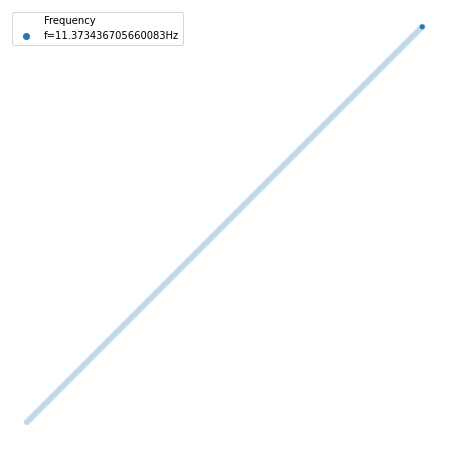

In [24]:
# Set up the figure
g, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
sns.despine(g, left=True, bottom=True)
ax.axis('off')
sns.scatterplot(x='$A_i$', y='$A_j$', hue='Frequency', data=mode_df, ax=ax, alpha=.5)

In [ ]:
# print(f'Metric avg: {metrics_df.groupby("Pipeline")["Entropy"].mean()}; std dev: {metrics_df.groupby("Pipeline")["Entropy"].std()}')
metrics_df.groupby('Pipeline')['Entropy'].std()
# metrics_df.groupby('Pipeline')['Mdt'].std()

In [ ]:
cl = [1,1,3,3,6,6,2,2,1,7,7,5,5,4,4]
no = len(np.unique(cl))
cva = np.random.permutation(no)+1
print(cva)
ncl = [np.where(cva==i)[0][0]+1 for i in cl]
print(ncl)

In [ ]:
# Number of areas after Watershed vs kernel size, watershed near neighbours
# (Default) near neighbours = 5 / kernel size = 2,3,4,5,...,15
# a1 = [351, 244, 162, 117, 78, 64]
k_sizes = np.arange(2,15)
min_d = [2,5,10]
areas = np.zeros(shape=(len(min_d),len(k_sizes)))
for i in range(len(min_d)):
    for j in range(len(k_sizes)):
        segmentation = Segmentation(low_dim_train.copy(), mode=0, mesh_mag=4000, xmax=600, ymax=600, 
                                    k_size=k_sizes[j], w_mind=min_d[i])
        areas[i,j] = np.ndarray.max(segmentation.labels)
        
# Plot Distibution
labels = ['min_dist = 2', 'min_dist = 5', 'min_dist = 10']
areas_df = pd.DataFrame(np.transpose(areas), columns=labels)
g = sns.lineplot(data=areas_df, palette="Set2", linewidth=1.5, dashes=False, alpha=.7, markers=True)
sns.despine(left=True, right=True, top=True, bottom=True)
g.set_xticks(range(len(k_sizes))) # <--- set the ticks first
g.set_xticklabels(k_sizes)
plt.title('Number of areas')
plt.xlabel('Gaussian convolution kernel size')

In [ ]:
# Evaluate BIC score of GMM segmentation by varying k, the number of components, and finding the knee of the curve.
n_components = np.arange(1,150)
models = [Segmentation(low_dim_train.copy(), mode=2, mesh_mag=1, xmax=500, ymax=500, gmm_comps=n) for n in n_components]

# Plot Distibution
labels = ['BIC', 'AIC']
crit_df = pd.DataFrame(np.transpose([[m.bic for m in models], [m.aic for m in models]]),
                       columns=labels)
g = sns.lineplot(data=crit_df, palette="Set2", linewidth=1.5, dashes=False, alpha=.7, markers=False)
sns.despine(left=True, right=True, top=True, bottom=True)
# g.set_xticks(range(len(np.arange(60,80)))) # <--- set the ticks first
# g.set_xticklabels(np.arange(60,80))
plt.title('Criteria for GMM model selection')
plt.xlabel('Number of mixture components')

In [ ]:
# Joint angle distributions
pipeline = list()
metric = list()
uncompactness = np.array([64.43903957, 62.8003689, 97.18088405,  6.69470362, 66.02925146,
       70.89262918, 81.29098176, 71.11798743,  87.12338481, 101.79853412,   3.79233881,
        59.78968349,  78.0055792,  91.86540651, 71.97687872,  87.64617883, 102.70819282,   7.79397312,
        62.02697388,  76.99554523,  90.56278743, 69.60936538,  89.14577305, 103.28848433,   6.40902407,
        60.4439792,  79.14273445,  91.70650077, 70.88587607, 68.55775965, 94.52163963,  7.74675606, 66.66728914,
       74.63865898, 79.71628103, 67.91067647,  64.84818835, 100.84700239,   7.59455491,
        65.82586534,  74.55067305,  83.95846576, 70.89978767,  84.09971393, 101.05731526,   5.67812047,
        63.41298957,  74.5579321,  88.83477808, 70.98224202, 84.08018857, 97.57163716,  6.63149757, 60.99601666,
       75.85490042, 89.20800474, 68.5102814, 83.63062028, 98.58075478,  6.30622722, 59.42134425,
       76.23551757, 88.81436172, 71.14922979,  85.8458922, 104.19539579,   3.954748,
        60.833886,  77.61409071,  90.59901544]) #/ 514.0580094688072
print(np.mean(uncompactness))

metric.extend(['Uncompactness' for i in range(len(uncompactness))])
pipeline.extend(['Joint_angles' for i in range(len(uncompactness))])

cent_dists = np.array([ 80.81274688,  89.45313808, 165.8194369,  99.34848304,
       150.09274403, 100.50518239,  65.20933639,  85.49117594,
       136.58781889, 111.00282607,  65.9027265 , 113.27998265,
        85.2841882,  60.73650363,  12.74536393, 198.5462081,
       113.84442394, 103.68008346, 117.95739786,  95.72204833,
        50.98495425, 39.83229996,  85.80201362, 160.52697398, 107.75272404,
       140.45926877,  81.94141154,  58.8355105, 175.19099303,
       110.29932062, 108.82686553,  57.6501532 , 151.79411893,
        79.00881569,  55.31568426,   6.65736487,  72.86589943,
       179.6687594 , 145.89515065, 110.73784218,  73.24635352,
        60.47120033, 40.13630382,  88.3221422, 175.22150677,  99.26256012,
       137.73253553,  86.03098234,  64.26722716, 185.75056903,
       100.79686244, 108.2386497,  59.92746007, 147.29386465,
        63.05742802,  50.39661681,   5.88671511,  86.85286549,
       164.95524791, 152.76715804,  95.48670682,  67.98400895,
        51.78981745, 44.61771081,  88.49031754, 141.88805927, 116.61814412,
       144.20881734,  85.82623918,  60.15147899, 172.56756778,
       125.78012853, 111.81170002,  61.43176963, 165.87892721,
        94.97629659,  55.77616726,   8.01463286,  83.30077321,
       202.77723207, 157.97573522, 121.5752117,  87.11453667,
        59.63218261, 75.19162361,  89.31622128, 179.83335992,  96.83341869,
       153.72091839, 102.02142284,  58.41217238, 105.54039042,
       124.8068088, 115.38259938,  60.57811387, 116.56613176,
        81.42688019,  65.50126882,  14.61569846, 197.25091029,
       115.43033993, 103.75222162, 110.76913272,  93.50643459,
        56.26934953, 86.50769256, 102.52904658, 180.87373679, 103.42238998,
       159.05192578, 109.09082402,  63.62672074,  95.93870117,
       137.13483903, 111.56444177,  63.70858694, 132.31233576,
        93.25064889,  57.29081643,   7.9721338, 223.30907016,
       145.78045139, 126.71710021, 121.20888772, 100.37647028,
        52.24443206, 38.08025547,  82.78667657, 150.71869849,  97.7135886 ,
       131.56015231,  82.23412868,  61.76228174, 166.48327952,
       100.77343167, 104.6136674 ,  58.92968586, 135.65243793,
        61.72218844,  49.92383462,   5.47897556,  73.93112677,
       161.19867355, 140.97111461,  92.71438159,  67.05272157,
        49.46846159, 41.52387573,  84.30373682, 139.02490423, 122.21945217,
       136.95540624,  82.73979014,  55.82850175, 167.55669415,
       126.38527294, 103.80079454,  57.56905525, 165.29996253,
        95.0021705 ,  53.15069841,   7.1812207 ,  93.57903411,
       205.1767266 , 158.47935097, 119.77506363,  87.9557723 ,
        56.56147805, 45.52411642,  84.6107443 , 151.43574271, 107.97443128,
       138.39800849,  82.45299316,  55.38548184, 177.3997016 ,
       115.16204015, 104.74091236,  57.76422984, 161.64695951,
        84.69386206,  53.84644614,   8.51006069,  80.44246528,
       191.24247671, 153.16777375, 110.94150265,  76.24921555,
        57.43919048, 42.30509535,  85.73427243, 157.7266939 , 111.10151228,
       142.44187765,  86.49892148,  57.09012553, 174.4000309 ,
       114.24258212, 109.08483219,  60.43029229, 152.27940796,
        82.68744035,  57.10142182,   6.05818375,  70.29075393,
       180.94637571, 146.52192682, 112.81034056,  76.78952648,
        57.7823497 ]) #/ 514.0580094688072 #/ 514.0580094688072 + 465.3993202587783 + 467.5749751308704
print(f'Pairwise dist mean: {np.mean(cent_dists)}')
metric.extend(['Centroid_pair_distances' for i in range(len(cent_dists))])
pipeline.extend(['Joint_angles' for i in range(len(cent_dists))])

In [ ]:
# 3D pose distributions
uncompactness2 = np.array([ 85.27971317,  87.71596198, 108.94591241,  68.62076803,
        89.84532752, 103.48768095,  84.73637024, 95.61013238, 86.98520396, 96.48325521, 49.59405512, 73.60529102,
       92.58949643, 86.52845216, 99.43752992,  80.81074761, 104.8335762 ,  81.00455205,
        81.88519475,  95.6218598 ,  87.79697373, 85.69131505,  85.84999174, 102.06982047,   7.83969741,
        78.00174271, 107.96486703,  91.16471791, 71.06289561,  78.71790049, 104.66547891,  45.5093896 ,
        93.1677574 ,  93.25335774,  92.40636167, 94.58986013,  89.34029835, 104.97500662,  83.94869498,
        72.65106753,  89.91405635,  86.18636973, 73.46393876,  78.20406024, 108.14447681,  39.46393357,
        99.48510176,  95.35220362,  93.92428645, 100.18474898,  85.50212092,  98.26468815,  51.94932728,
        75.2238792 ,  92.51278624,  89.31297383, 81.95865402,  80.57825599, 102.13631323,   7.44788758,
        92.72945415,  91.17006372,  87.70209701, 71.46871058,  81.12915434, 106.92474228,  57.90366412,
       107.99191031, 105.32077816,  89.92355291]) #/ 507.42743042725465 #/ 507.42743042725465
print(np.mean(uncompactness2))
metric.extend(['Uncompactness' for i in range(len(uncompactness2))])
pipeline.extend(['3D_pose' for i in range(len(uncompactness2))])

cent_dists2 = np.array([ 61.24459769,  96.4696448 , 107.59890196,  99.29463505,
       138.10728333, 103.98685597,  48.34888064,  56.04358809,
        55.26603226,  94.02525806,  53.89909782,  82.42198459,
         8.83420788,  45.70351265,   7.77551674,  91.25605161,
       119.57951282,  82.94079578,  39.86958336,  11.68771891,
        40.56244247, 21.00170003,  60.28365364,  30.92706067,  95.9264154 ,
       117.06652529,  69.46633866,  69.08727168,  41.64994216,
       111.74589842, 122.05575088,  72.32072177,  88.23502089,
        52.06798368,  57.75497123,  20.93023898, 114.5863828 ,
       145.89137476,  99.72541852,  68.99650809,  68.59578316,
        49.89311481, 12.7967339 ,  75.32611384,  94.91942763, 100.49943638,
       127.396569  ,  79.67177258,  65.87364859,  82.16347424,
        88.03951464, 119.21142364,  70.45408327,  65.32578285,
        47.38169538,  54.2905169 ,   4.87740936,  28.69874514,
       102.13143636,  68.12342341,  74.34898625,  48.47075367,
        49.4455219 , 24.07035428,  64.56118996,  97.03745958, 105.72306005,
       118.1728735 ,  75.81140862,  49.64859927, 105.31583985,
        93.72643116,  98.58131283,  54.4122355 , 154.95057099,
        44.38085829,  56.06268972,  26.78457905, 198.9869284 ,
       199.37372541, 154.51253923,  44.98329536,  57.11538106,
        45.02089588, 28.90190282,  77.62969624,  88.32276506, 112.80385966,
       131.15980618,  90.38603154,  50.96406516,  65.29635304,
        97.58348286, 102.25829666,  63.95913321,  69.78166255,
        64.53207023,  62.03381928,  13.00042545, 134.29434183,
        72.21994785,  76.85875867, 107.22967175,  59.83755935,
        55.08725349, 43.17036398,  78.50314372, 108.80712379, 118.7269683 ,
       138.6409541 ,  87.76697765,  48.15294296,  65.68137115,
        77.68118885, 105.51364124,  58.09422947,  62.85088183,
        50.46197476,  60.17246506,   9.98250907,  34.09775141,
        81.14888116,  65.83854322,  47.36104666,  48.03505436,
        50.95008098, 31.11469551,  77.96353514,  90.98656409,  96.61660017,
       128.13519683,  86.25343776,  55.33749224,  60.21124312,
        94.31375128, 100.53973033,  64.79033717,  61.31534533,
        64.48763854,  53.51585338,   9.71931082, 124.79305358,
        68.6059245 ,  68.27812864, 103.10511385,  60.51405647,
        49.32388189,  7.77481949,  67.19066063,  47.00599228, 101.90358516,
       115.66322788,  64.66182217,  74.08159527,  39.70216318,
       105.49410658, 122.27649753,  71.17799209, 104.86572026,
        61.05306558,  48.79446353,   7.1424028 , 117.47129807,
       149.73208112, 100.14145121,  60.87216666,  55.66251335,
        51.10660328, 83.36534144, 116.33349179,  75.96766486, 131.47539016,
       148.1513587 , 108.34896322,  49.37380811,  26.54337128,
        88.41742848,  76.91629441,  41.61391088,  75.84998643,
        45.52164819,  31.81787393,   8.40695382, 114.23036541,
       102.27349951,  68.15497574,  51.25651651,  49.86880875,
        39.91150195, 53.27060224,  95.12547836,  35.81101606, 102.40511181,
       119.13137059,  92.81164503,  55.80635783,  88.3937346 ,
        69.70718115,  87.48840637,  59.11419158, 123.2213589 ,
        17.20483743,  33.14756716,  10.68415001, 126.9525646 ,
       141.88971654, 118.67705558,  17.87256527,  10.63318341,
        28.50205783]) #/ 507.42743042725465
print(f'Pairwise dist mean: {np.mean(cent_dists2)}')
metric.extend(['Centroid_pair_distances' for i in range(len(cent_dists2))])
pipeline.extend(['3D_pose' for i in range(len(cent_dists2))])
frm_data = np.concatenate((uncompactness, cent_dists, uncompactness2, cent_dists2))

In [ ]:
assert len(metric) == len(pipeline) == len(frm_data)
fly_dist_df = pd.DataFrame()
fly_dist_df['Metric']=pd.Series(metric)
fly_dist_df['Pipeline']=pd.Series(pipeline)
fly_dist_df['Metric/Diagonal']=pd.Series(frm_data)
fly_dist_df

In [ ]:
%matplotlib inline
f, ax = plt.subplots(figsize=(5, 5))
# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(x="Metric", y="Metric/Diagonal", hue="Pipeline",
               split=True, inner="quart",
               palette={"Joint_angles": sns.color_palette("PuOr", n_colors=12, desat=.9)[8],
                        "3D_pose": sns.color_palette("PuOr", n_colors=12, desat=.7)[3]},
               data=fly_dist_df)
sns.despine(left=True, bottom=True)
# EXTRACT CURRENT HANDLES AND LABELS
h,l = ax.get_legend_handles_labels()
# COLOR LEGEND (FIRST 30 ITEMS)
col_lgd = plt.legend(h, l, loc='upper left', 
                     bbox_to_anchor=(0.15, -0.12), fancybox=False, shadow=False, ncol=5)

In [ ]:
# lets say I want to see frames 10 to 20 from a Fly experiment #3
# train_frame_index[ar_frm][train_exp_index[ar_frm]==exp_idx]
min_f = np.where(train_exp_index == 3)[0][10]
max_f = np.where(train_exp_index == 3)[0][20]
np.shape(train_data[min_f:max_f])

In [ ]:
b = ['name_tag1', 'name_tag2']
a = ['save_directory/'] * len(b)
[f'{a_}{b_}' for a_, b_ in zip(a, b)]

In [ ]:
# import cmasher as cmr
# cmap = cmr.redshift
# sns.palplot(sns.diverging_palette(250, 20, center='dark', l=40, s=70, n=10, as_cmap=False))
# sns.palplot(sns.cubehelix_palette(n_colors=80, start=2, rot=1, gamma=.9,
#                                   hue=.9, light=0.95, dark=0.01, reverse=True, as_cmap=False))
sns.palplot(sns.color_palette('magma', n_colors=10, desat=.7))